# Validation of profile simulation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from stingray.pulse.search import epoch_folding_search
from stingray.pulse.modeling import fit_gaussian 
from shapely.geometry import LineString
# from tatpulsar.pulse.fold import cal_event_gti
from tatpulsar.utils.functions import cal_event_gti
from tatpulsar.pulse import search

from tatpulsar.pulse import fold, search
from tatpulsar.pulse.fold import phihist
from tatpulsar.data import Profile
from tatpulsar.utils.functions import *
import seaborn as sns
from astropy.io import fits
import warnings
import matplotlib as mpl
import glob
%matplotlib inline
mpl.rcParams['figure.figsize'] = (15,10)
# sns.set_context('talk')
# sns.set_style("whitegrid")
# sns.set_palette("colorblind")
plt.style.use(['science', 'nature', 'no-latex'])
mpl.rcParams['figure.dpi'] = 250
import warnings
warnings.filterwarnings('ignore')  

np.random.seed(20220901)

/Users/tuoyouli/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/Users/tuoyouli/anaconda3/lib/python3.7/site-packages/stingray/largememory.py:26: UserWarning: Large Datasets may not be processed efficiently due to computational constraints
  "Large Datasets may not be processed efficiently due to "
/Users/tuoyouli/anaconda3/lib/python3.7/site-packages/stingray/crossspectrum.py:28: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn("pyfftw not installed. Using standard scipy fft")
/Users/tuoyouli/anaconda3/lib/python3.7/site-packages/stingray/crosscorrelation.py:8: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn("pyfftw not installed. Using standard scipy fft")
/Users/tuoyouli/anaconda3/lib/python3.7/site-packages/stingray/bispectrum.py:10: UserWarning: pyfftw not i

## Modelling Crab pulsar profile

In [2]:
from astropy.modeling import models, fitting, custom_model
# Define model
@custom_model
def sum_of_gaussians(x, baseline=0,
                        amplitude1=1., mean1=-1., sigma1=1.,
                        amplitude2=1., mean2=1., sigma2=1.):

    funval0 = (amplitude1 * np.exp(-0.5 * ((x - mean1) / sigma1)**2) +
               amplitude2 * np.exp(-0.5 * ((x - mean2) / sigma2)**2))
    funval1 = (amplitude1 * np.exp(-0.5 * ((x - mean1 - 1) / sigma1)**2) +
               amplitude2 * np.exp(-0.5 * ((x - mean2 - 1) / sigma2)**2))
    funval2 = (amplitude1 * np.exp(-0.5 * ((x - mean1 + 1) / sigma1)**2) +
               amplitude2 * np.exp(-0.5 * ((x - mean2 + 1) / sigma2)**2))

    return baseline + funval0 + funval1 + funval2

def double_gauss(phase, profile):
    height = np.max(profile) - np.min(profile)
    peak = phase[np.argmax(profile)]
    mod = sum_of_gaussians(baseline=np.mean(profile), 
                           mean1=peak, mean2=peak + 0.4,
                           amplitude1=height, amplitude2=height/2,
                           sigma1=0.02, sigma2=0.02)
    def x_1_p_0d4(mod): return mod.mean1 + 0.4
    mod.mean2.tied = x_1_p_0d4
    fitter = fitting.LevMarLSQFitter()

    newmod = fitter(mod, phase, profile)
    fine_phase = np.arange(0, 1, 0.0001)
    fine_template = newmod(fine_phase)
    additional_phase = fine_phase[np.argmax(fine_template)]
    plt.figure()
    plt.plot(phase, profile)
    allph = fine_phase
    plt.plot(allph, mod(allph), ls='--')
    plt.plot(allph, newmod(allph))
    return newmod, additional_phase

def skewed_moffat(x, mean, amplitude, alpham, alphap, beta):
    lt0 = (x-mean) < 0
#     gt0 = np.logical_not(lt0)
    ratio = ((x-mean)/alphap)**2
    ratio[lt0] = ((x[lt0]-mean)/alpham)**2
    return amplitude * ( 1 + ratio)**(-beta)

# Define model
@custom_model
def sum_of_moffats(x, baseline=0,
                   amplitude1=1., mean1=0., alpham1=0.05, alphap1=0.05, beta1=1,
                   amplitude2=1., mean2=0.4, alpham2=0.05, alphap2=0.05, beta2=1):

    funval0 = (skewed_moffat(x, mean1, amplitude1, alpham1, alphap1, beta1) +
               skewed_moffat(x, mean2, amplitude2, alpham2, alphap2, beta2))
    funval1 = (skewed_moffat(x - 1, mean1, amplitude1, alpham1, alphap1, beta1) +
               skewed_moffat(x - 1, mean2, amplitude2, alpham2, alphap2, beta2))
    funval2 = (skewed_moffat(x + 1, mean1, amplitude1, alpham1, alphap1, beta1) +
               skewed_moffat(x + 1, mean2, amplitude2, alpham2, alphap2, beta2))

    return baseline + funval0 + funval1 + funval2


<ErrorbarContainer object of 3 artists>

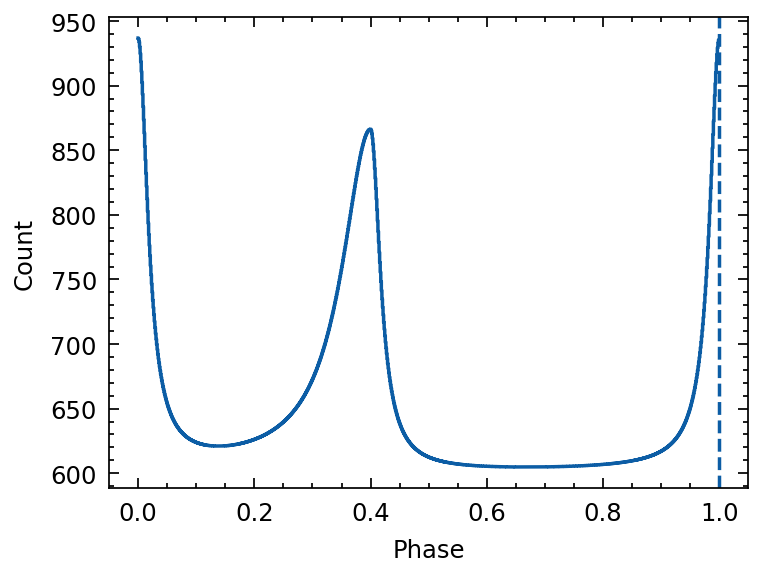

In [10]:
# Create light curve

mod = sum_of_moffats(baseline=600, 
                     mean1=0.0, mean2=0.4,
                     amplitude1=10*33, amplitude2=8*33,
                     alpham1=0.02, alpham2=0.06, alphap1=0.02, alphap2=0.02)

phases = np.arange(0, 1, 1/1024)
template = mod(phases)
from tatpulsar.data import Profile
template = Profile(template, cycles=1)

plt.figure()
plt.axvline(x=1, ls='--')
plt.xlabel("Phase")
plt.ylabel("Count")
plt.errorbar(template.phase, template.counts, ds='steps-mid')

## Draw phase of Photons

In [11]:
from scipy.interpolate import interp1d
# pro_interp = inter1d(template.phase, template.counts, kind='cubic')

def rejection_sampling(x, y, nphot):
    """
    rejection sampling the poisson like signal x-y
    
    x: array-like
        Time or Phase array
        
    y: array-like
        counts, Poisson distributed
    
    nphot: int
        The output amount of sampled photons
    """
    binsize = np.median(np.diff(x))
    interp_fun = interp1d(np.append(x, x.max()+binsize),
                          np.append(y, y[0]),
                          kind='cubic')
    # interp_fun = interp1d(x,
    #                   y,
    #                   kind='cubic')


    
    x_sample = np.random.uniform(x.min(), x.max()+binsize, nphot)
    # x_sample = np.random.uniform(x.min(), x.max(), nphot)
    yval_x_sample = interp_fun(x_sample) # The corresponding y value of sampled X, according to interplation function
    
    y_sample = np.random.uniform(0, y.max(), nphot) # Sampled y value for each x sampled value
    ## Reject the value that over the true y value
    mask = (y_sample <= yval_x_sample)
    
    return x_sample[mask]

In [12]:
np.random.seed(20230723)
photon_num = 2000000
sample_phase = rejection_sampling(template.phase, template.counts, photon_num)


<ErrorbarContainer object of 3 artists>

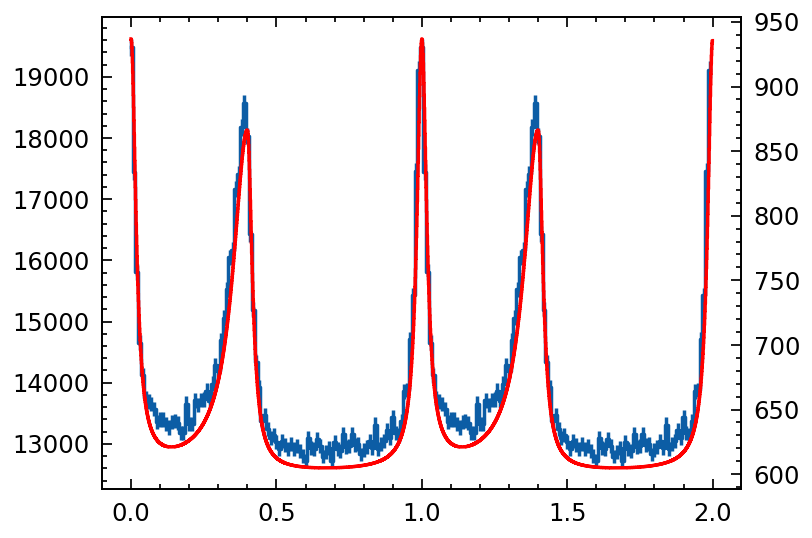

In [13]:
p = phihist(sample_phase, nbins=100)
p.cycles=2
template.cycles=2
# p.norm()
# template.norm()
plt.errorbar(p.phase, p.counts, p.error, label='sampled', ds='steps-mid')
plt.twinx()
plt.errorbar(template.phase, template.counts, ds='steps-mid', c='r')
# plt.figure(figsize=(3,1))
# plt.errorbar(p.phase, template.counts-p.counts)


NOTE: The rejection sample of the given model profile is valid!
Now let's take a look at the photon arrival time sampling based on the profile.

## Compute arrival time of simulated photons

In [14]:
from scipy.optimize import brentq
from tqdm import tqdm
import numpy as np

def draw_time_from_phase(phase, tstart, tstop, f0=0, f1=0, f2=0, f3=0, pepoch=0):
    """
    sampling the photon arrival time given the phase of each photon
    
    Parameters
    ----------
    phase: array-like
        The phase of each photon, the phase is normalized to [0, 1]
    tstart: array-like
        The start time to generate arrival time (MJD)
    tstop: array-like
        The stop  time to generate arrival time (MJD)

    par: float
        The following parameters are pulsar periodic parameters
    """
    
    dt = (tstart - pepoch) * 86400
    tstart_phase = f0*dt + 0.5*f1*dt**2 + (1/6.)*f2*dt**3
    dt = (tstop  - pepoch) * 86400
    tstop_phase  = f0*dt + 0.5*f1*dt**2 + (1/6.)*f2*dt**3

    Npulse_sample = np.random.randint(tstart_phase, tstop_phase, phase.size)

    absphase_sample = Npulse_sample + phase

    def delta_phi(t, phi0):
        dt = (t - pepoch) * 86400
        return f0*dt + 0.5*f1*dt**2 + (1/6.)*f2*dt**3 - phi0
    
    def obj_fun(t):
        return delta_phi(t, phi)

    new_event = np.empty_like(phase)

    for idx, phi in enumerate(tqdm(absphase_sample)):
        new_event[idx] = brentq(obj_fun, tstart, tstop)
    
    return new_event


In [15]:
from tatpulsar.utils.functions import met2mjd

mjd_tstart = 59000
mjd_tstop  = 60000
f0 = 29.6366215666433
f1 = -3.69981e-10
f2 = -8.1e-18
pepoch = 58068
out = draw_time_from_phase(sample_phase,
                       mjd_tstart,
                       mjd_tstop,
                       f0=f0,
                       f1=f1,
                       f2=f2,
                       pepoch=pepoch)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1393858/1393858 [00:07<00:00, 198657.71it/s]


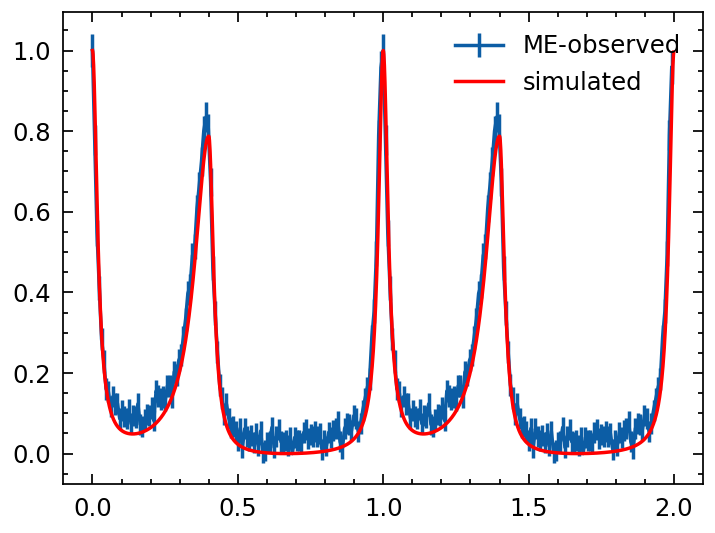

In [18]:
from tatpulsar.data.profile import phihist
from tatpulsar.pulse.fold import cal_phase, fold
# phase = cal_phase(mjd2met(out, 'nicer'), mjd2met(pepoch, 'nicer'), f0, f1=0, f2=0, f3=0, f4=0, format='met', phi0=0)
# real_pro = phihist(phase, nbins=1024, cycles=1)

real_pro = fold(out, pepoch=pepoch, f0=f0, f1=f1, f2=f2, nbins=128, format='mjd')
real_pro.cycles=2

real_pro.norm()
template.norm()
plt.errorbar(real_pro.phase, real_pro.counts, real_pro.error, label='ME-observed')
# plt.twinx()
plt.errorbar(template.phase, template.counts,
             c='r', label='simulated')
plt.legend()


The event list is simulated according to the phase samples, resulting in calculated outcomes. Subsequently, a profile is generated based on this sampled event list, aligning effectively with the template profile. This suggests that the entire simulation process—from the template profile to the photon's arrival time—is both valid and reliable.

## more tests

In [ ]:
from tatpulsar.data.profile import draw_random_pulse
profile_random = draw_random_pulse(nbins=100, baseline=1000, pulsefrac=0.9)
plt.errorbar(profile_random.phase, profile_random.counts)
help(profile_random.sampling_phase)